In [68]:
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import random
import torch
import src.wrappers.wrapers as wrapers
import json
from pathlib import Path

tl_big = matplotlib.colormaps['twilight_shifted'].resampled(int(1e3))
tl_resc = matplotlib.colors.ListedColormap(tl_big(np.linspace(0.075, 0.925, 10000)))

def load_model(model_path):
    path = Path(model_path)
    
    config = json.load(open(path.parent.parent/'config.json'))
    checkpoint = torch.load(path.as_posix(), map_location=torch.device('cuda:0'))
    
    model = getattr(wrapers, config["MODEL_WRAPER"])(config)
    model.load_state_dict(checkpoint['state_dict'])

    return model, config

def predict(model, full_vertex, positional_encoding: bool):   
    pred = np.zeros_like(full_vertex)
    for i in range(full_vertex.shape[0]):
        for j in range(full_vertex.shape[1]):
            r = random.randint(0, full_vertex.shape[2] - 1)
            pos = []
            
            if positional_encoding:
                pos = [i, j, r]

            dim1 = full_vertex[i, j, :]
            dim2 = full_vertex[i, :, r]
            dim3 = full_vertex[:, j, r]
            full_input = torch.tensor([*pos, *dim1, *dim2, *dim3], dtype=torch.float32)
            pred[i, j, :] = model(full_input.to("cpu")).detach().numpy()
            del dim1, dim2, dim3, full_input
    return pred

def get_vertex_from_filepath(path: str):
    with h5py.File(path, 'r') as f:
        for name, data in f["V"].items():
            if name.startswith("step"):
                return data[()]
            
def create_graph(data, name: str, figSize = (12,7), lim = None, ylabel = None, use_keys = True, x_label = 'out_dim'):

    marker = "o"

    # plot
    plt.rcParams['figure.figsize'] = figSize

    plt.plot(data.keys(), data.values(), marker=marker)

    plt.title(name, fontsize=15)
    plt.ylabel(name if not ylabel else ylabel, fontsize=12)
    if lim:
        plt.ylim(lim)
    if use_keys:
        plt.xticks(sorted(list(data.keys())))
    plt.xlabel(x_label, fontsize=12)
    plt.show()


class Container:
    def __init__(self) -> None:
        self.mse = dict()
        self.k3_0 = dict()
        self.k3_128 = dict()
        self.k3_255 = dict()
        self.sum = dict()
        self.eigvec = dict()
        self.eigval = dict()
        self.cr = dict()

    def extract_stats(self, config, data, prediction, index, data_sum = None):
        data_sum = np.sum(data) if not data_sum else data_sum
        self.mse[index] = np.square(data - prediction).mean()
        self.k3_0[index] = prediction[:, :, 0]
        self.k3_128[index] = prediction[:, :, 128]
        self.k3_255[index] = prediction[:, :, 255]
        self.sum[index] = abs((np.sum(prediction) / data_sum) - 1)

        eigenvalues, eigenvectors = np.linalg.eig(prediction[:,:,0])

        self.eigval[index] = eigenvalues[:10]
        self.eigvec[index] = np.abs(eigenvectors[:10,np.argmax(np.abs(eigenvalues))])
        self.cr[index] = 1 - config["encoder_dim"] / config["out_dim"]

def plot_comparison_grid(data, dictionary, k3, plotsize = (2,4)):
    original = data[:, :, k3]

    fig, axs = plt.subplots(plotsize[0], plotsize[1])
    axs = axs.flatten()

    for ax, idx, img in zip(axs, ["original", *dictionary.keys()],[original, *dictionary.values()]):

        im = ax.imshow(img, cmap=tl_resc, vmax=20)

        # remove ticks
        ax.set_xticks([]) 
        ax.set_yticks([])

        ax.set_xlabel(r"$k_1$")
        ax.set_ylabel(r"$k_2$")

        if idx == "original":
            ax.set_title("Original vertex", fontsize=10)
        else:
            ax.set_title(f"Rec. with n={idx}", fontsize=10)

    fig.colorbar(im, ax=axs)
    fig.suptitle(f"Rec. for k3 = {k3}")

def plot_squared_errors_grid(data, dictionary, k3, plotsize = (2,4)):
    original = data[:, :, k3]

    fig, axs = plt.subplots(plotsize[0], plotsize[1])
    axs = axs.flatten()

    for ax, idx, img in zip(axs, ["original", *dictionary.keys()],[original, *dictionary.values()]):

        im = ax.imshow(np.square(img - original), cmap=tl_resc, vmax=20)

        # remove ticks
        ax.set_xticks([]) 
        ax.set_yticks([])

        ax.set_xlabel(r"$k_1$")
        ax.set_ylabel(r"$k_2$")

        if idx == "original":
            ax.set_title("Original Vertex Err.", fontsize=10)
        else:
            ax.set_title(f"Rec. Err. with n={idx}", fontsize=10)

    fig.colorbar(im, ax=axs)
    fig.suptitle(f"Rec. Err. for k3 = {k3}")


def create_marker_graph(name: str, dictionary, original_result, *args, figSize = (12,7), lim = None,xlabel = None, ylabel = None):

    # Define markers for different betas.

    markers = ["s", "o", "v", "*", "X", "^", "<", ">", "8", "p", "h", "H", "d", "P", ".", "D"]

        # plot
    plt.rcParams['figure.figsize'] = figSize

    plt.plot(np.abs(original_result), label="Original", marker=markers[-1])

    marker_counter = 0

    for k, v in dictionary.items():
        plt.plot(np.abs(v), marker=markers[marker_counter], label=f"n={k}")
        marker_counter += 1

    plt.title(name, fontsize=15)
    plt.ylabel(name if not ylabel else ylabel, fontsize=12)
    if xlabel:
        plt.xlabel(xlabel)
    if lim:
        plt.ylim(lim)
    plt.legend()
    plt.show()

In [6]:
models = [
    "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS20_2024-07-25\\version_0\\checkpoints\\epoch=256-step=719600.ckpt",
    "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS20_2024-07-25\\version_1\\checkpoints\\epoch=148-step=417200.ckpt",
    "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS20_2024-07-25\\version_2\\checkpoints\\epoch=175-step=492800.ckpt",
    "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS20_2024-07-25\\version_3\\checkpoints\\epoch=252-step=708400.ckpt",
    "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS20_2024-07-25\\version_4\\checkpoints\\epoch=159-step=448000.ckpt",
    "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS20_2024-07-25\\version_5\\checkpoints\\epoch=163-step=459200.ckpt",
    "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS20_2024-07-25\\version_6\\checkpoints\\epoch=83-step=235200.ckpt"
]
data_path = "D:\\FRGS\\tp0.050000_mu0.200000.h5"

data = np.array(get_vertex_from_filepath(data_path))
data_sum = np.sum(data)

container = Container()

for model_path in models:
    model, config = load_model(model_path)
    model.model.eval()
    prediction = predict(model, data, positional_encoding=config["positional_encoding"])
    index = config["encoder_dim"]
    container.extract_stats(config, data, prediction, index)

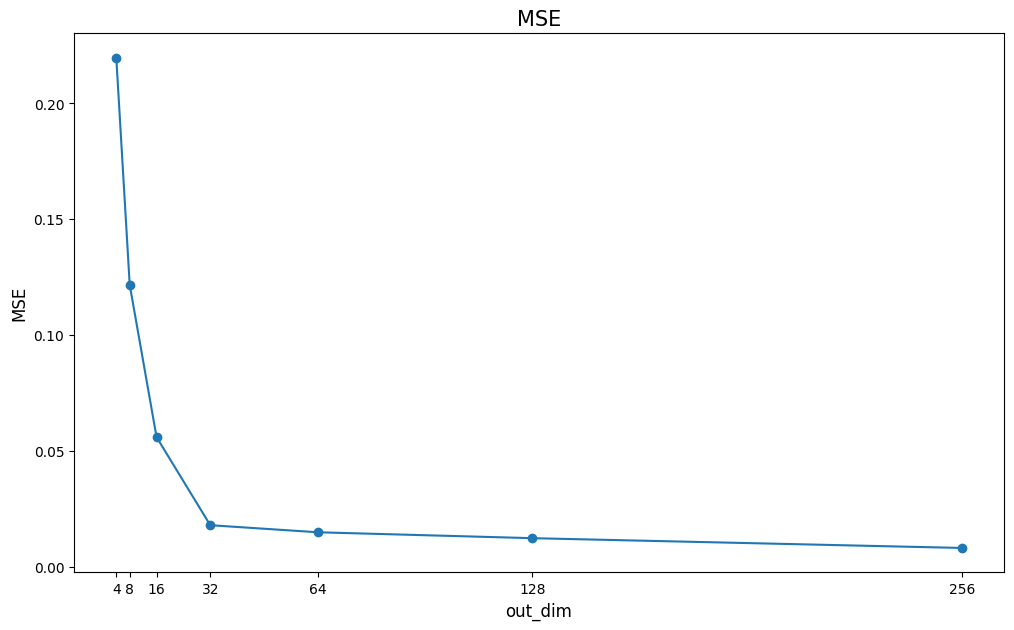

In [7]:
create_graph(container.mse, "MSE")

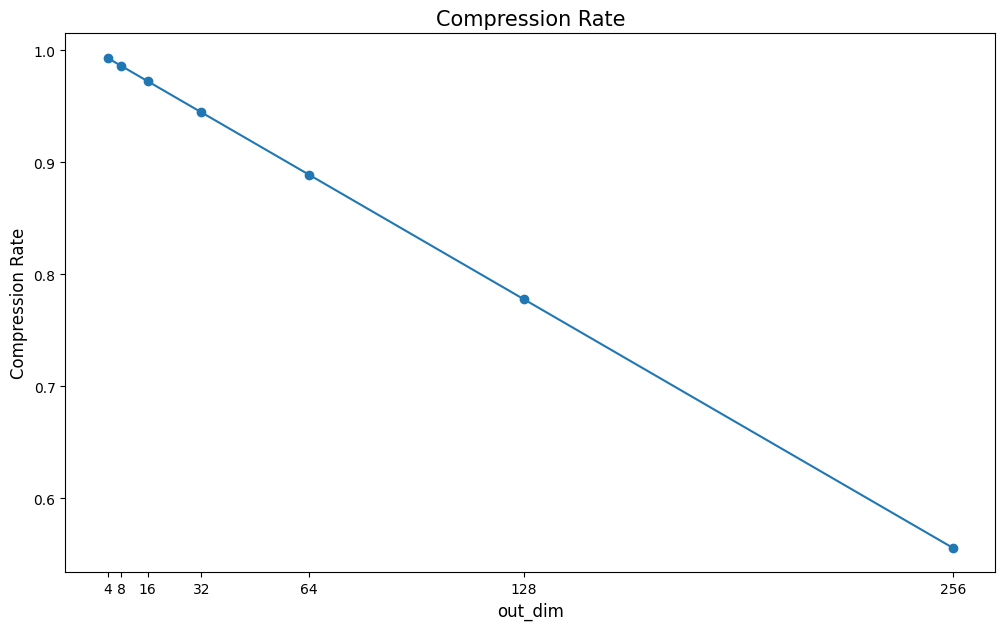

In [8]:
create_graph(container.cr, "Compression Rate")

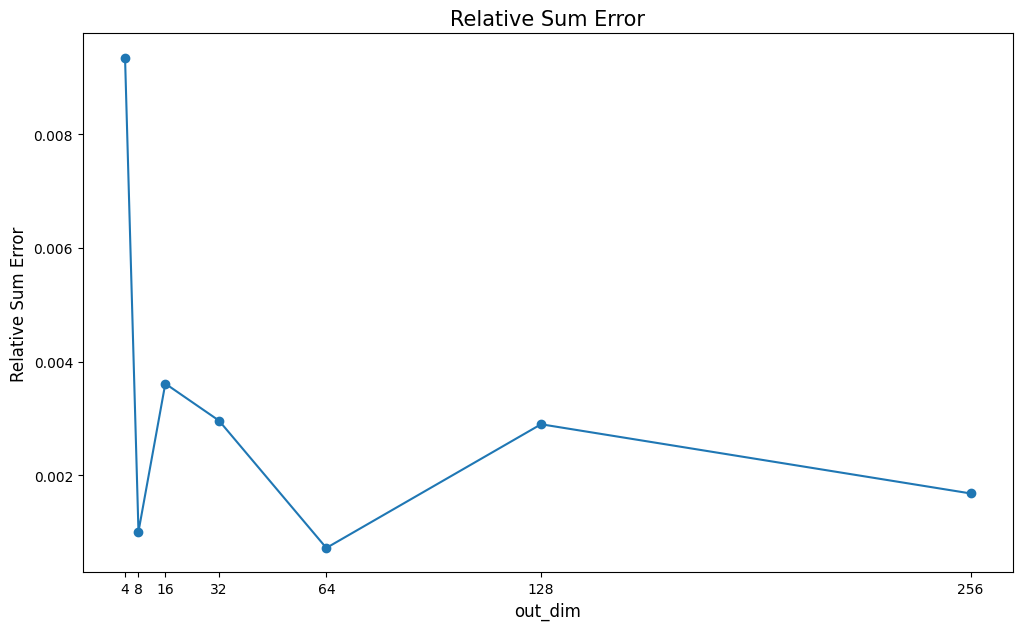

In [19]:
create_graph(container.sum, "Relative Sum Error")

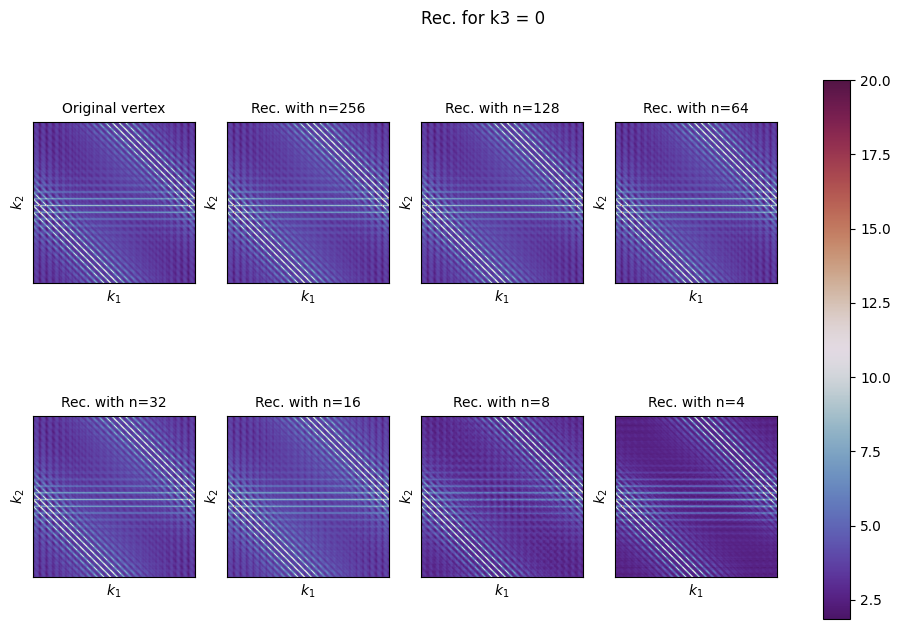

In [64]:
plot_comparison_grid(data, container.k3_0, 0)

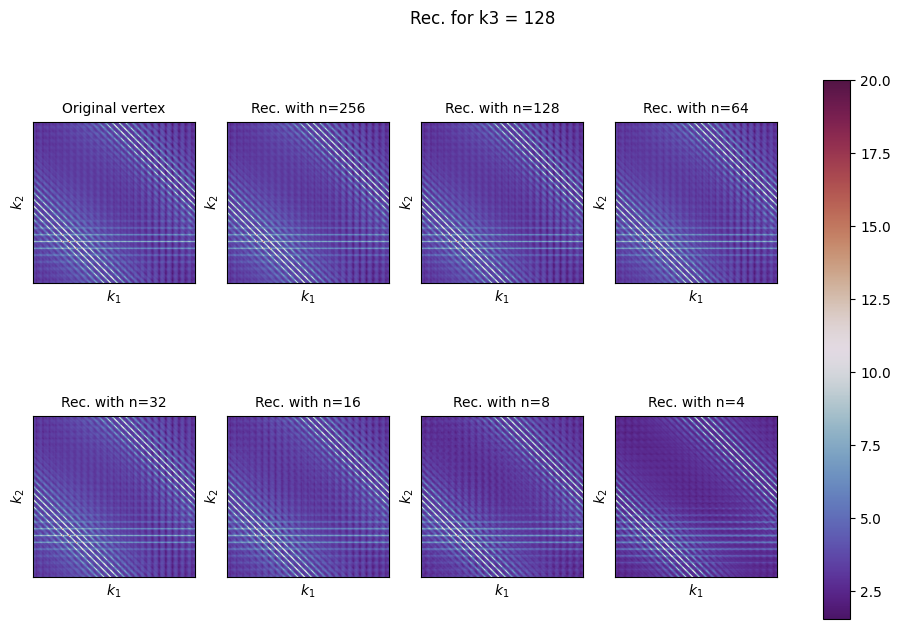

In [65]:
plot_comparison_grid(data, container.k3_128, 128)

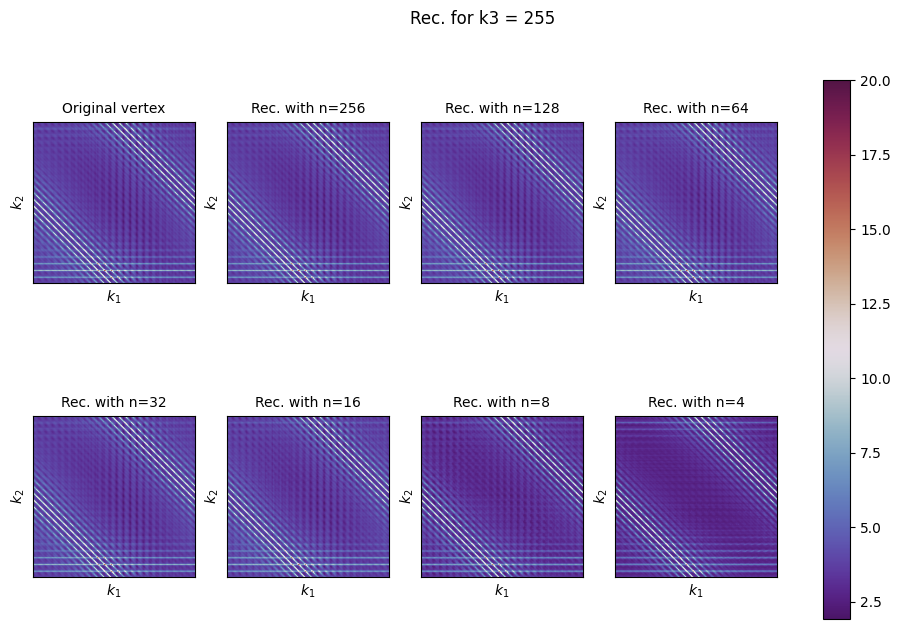

In [66]:
plot_comparison_grid(data, container.k3_255, 255)

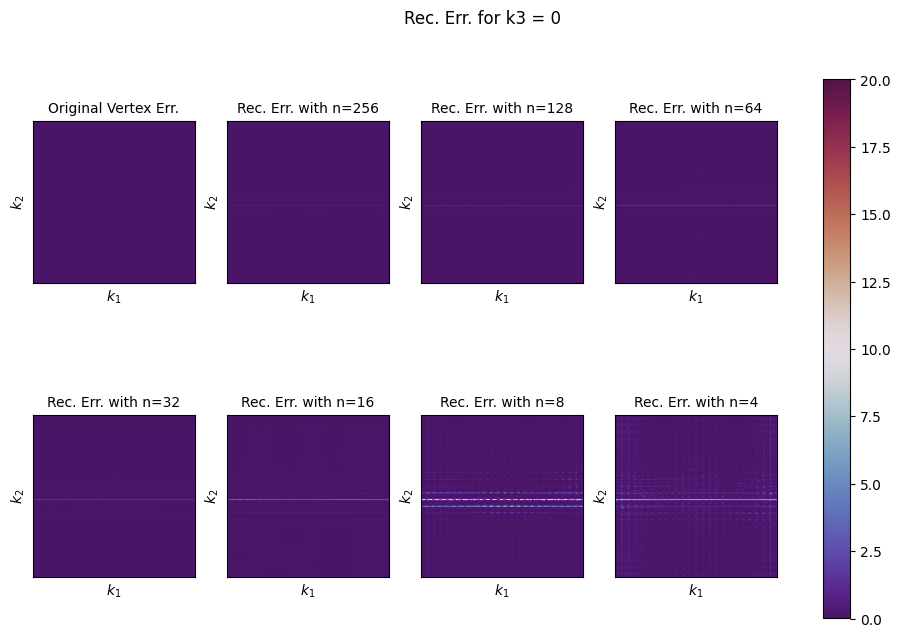

In [69]:
plot_squared_errors_grid(data, container.k3_0, 0)

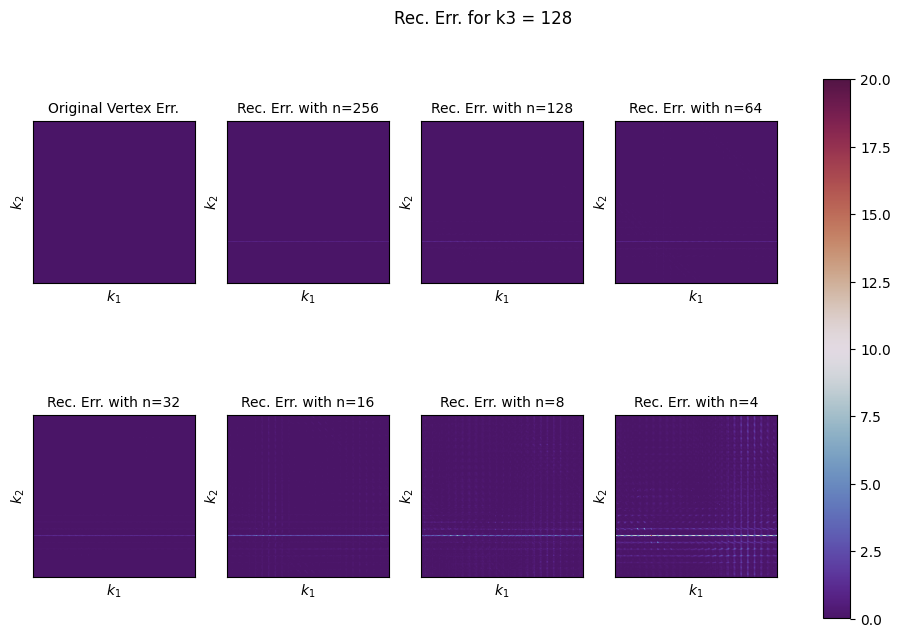

In [70]:
plot_squared_errors_grid(data, container.k3_128, 128)

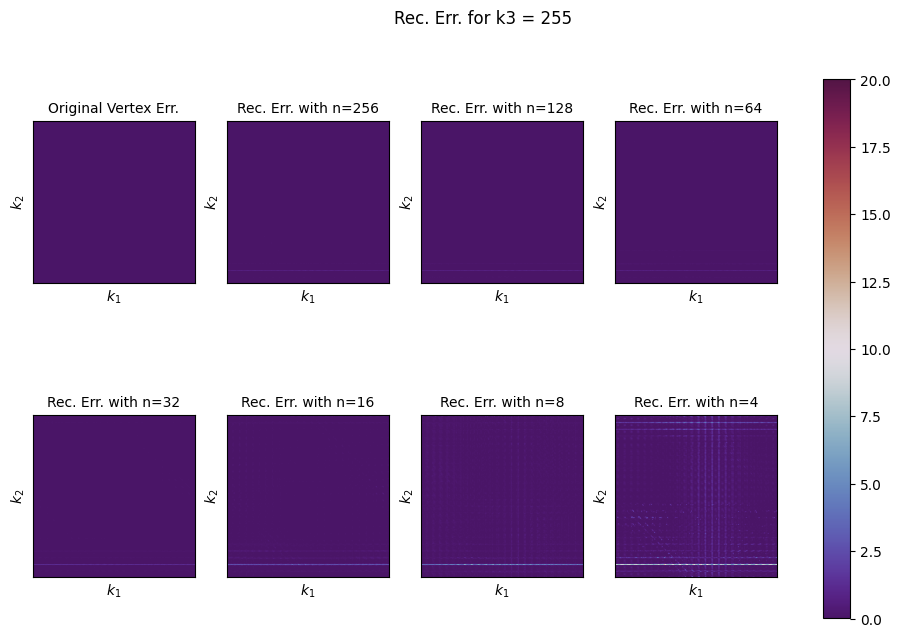

In [71]:
plot_squared_errors_grid(data, container.k3_255, 255)

In [51]:
eigenvalues, eigenvectors = np.linalg.eig(data[:,:,0])
original_eigval = eigenvalues[:10]
original_eigvec = np.abs(eigenvectors[:10,np.argmax(np.abs(eigenvalues))])

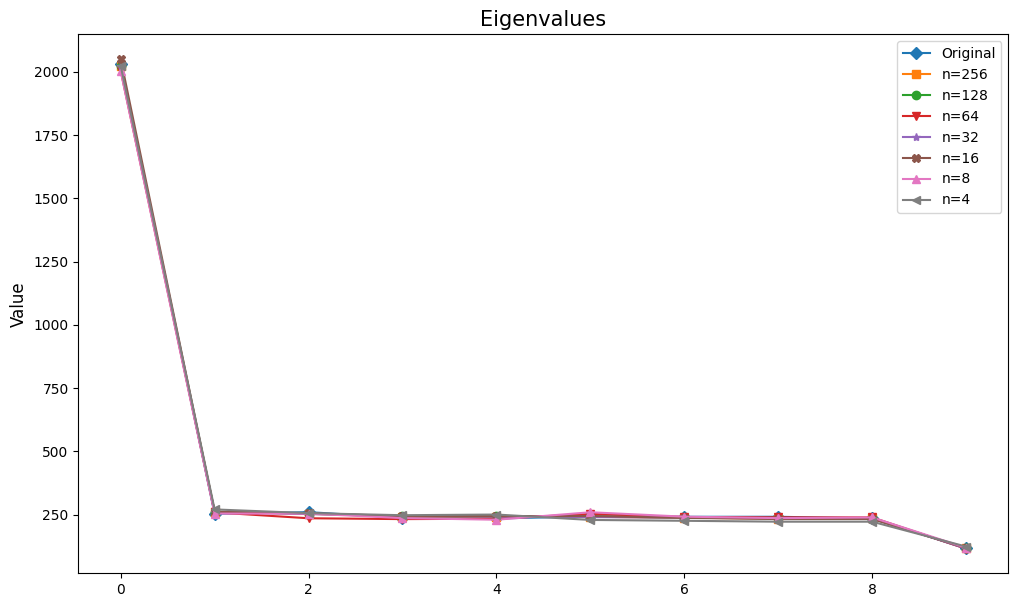

In [59]:
create_marker_graph("Eigenvalues", container.eigval, original_eigval, ylabel="Value")

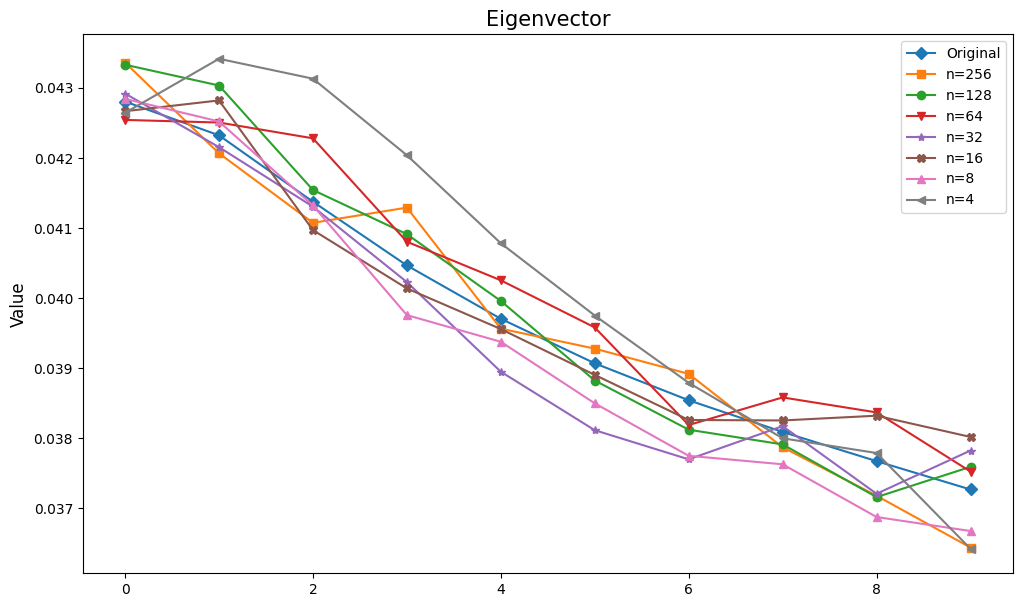

In [60]:
create_marker_graph("Eigenvector", container.eigvec, original_eigvec, ylabel="Value")

In [ ]:
if False:
    models = [
        "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS10_2024-07-16\\version_0\\checkpoints\\epoch=149-step=840000.ckpt",
        "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS10_2024-07-16\\version_8\\checkpoints\\epoch=99-step=560000.ckpt",
        "C:\\Users\\Daniel\\OneDrive - TU Wien\\Uni\\6. Semester\\Bachelorarbeit\\autoencoder\\LuttingerWard_from_ML\\saves\\vertex\\save_auto_encoder_vertex_BS10_2024-07-16\\version_9\\checkpoints\\epoch=99-step=2800000.ckpt",
    ]
    data_path = "D:\\FRGS\\tp0.050000_mu0.200000.h5"

    data = np.array(get_vertex_from_filepath(data_path))
    data_sum = np.sum(data)

    container2 = Container()

    for model_path in models:
        model, config = load_model(model_path)
        model.model.eval()
        prediction = predict(model, data, positional_encoding=config["positional_encoding"])
        mse = np.square(data - prediction).mean()
        index = f"{config["batch_size"]}{config["positional_encoding"]}"
        container2.extract_tats(config, data, prediction, index)